In [ ]:
#%run NB01-Load.ipynb

In [1]:
import collections
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.plotly as py
import random 
#import seaborn as sb
import seaborn as sns
#import seaborn as snss
import sklearn
import statsmodels.api as sm
import warnings

from datetime import date
from IPython.display import HTML
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from pandas import DataFrame
from pandas import Series
from plotly import tools
from plotly.offline import init_notebook_mode
from plotly.offline import iplot
from pylab import rcParams
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
#from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud

init_notebook_mode(connected=True)
plt.rcParams.update({'figure.max_open_warning': 200})
warnings.filterwarnings("ignore")

%matplotlib inline

#import C:/Development/kaggle--home-credit-default-risk/rand_jitter
#import C:/Development/kaggle--home-credit-default-risk/draw_feature_distribution
import sys
# sys.path.insert(0, 'C:/Development/kaggle--home-credit-default-risk/') # ~= sys.path.prepend
sys.path.append('C:/Development/kaggle--home-credit-default-risk/')
# import rand_jitter
# import draw_feature_distribution
##from rand_jitter import * # NOTE: added directly to draw_feature_distribution_v2
# from draw_feature_distribution import *
# from draw_feature_distribution_v1 import *
from draw_feature_distribution_v2 import *

# C:\Users\jbalcomb\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:
# The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


C:\Users\jbalcomb\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [2]:
path = "C:/Development/kaggle--home-credit-default-risk/data/"

In [3]:
#application_train = pd.read_table(path + 'application_train.csv', sep=',', dtype=object)
application_train = pd.read_table(path + 'application_train.csv', sep=',')

In [ ]:
#df = application_train

In [ ]:
application_train.head()

In [ ]:
application_train.columns.tolist()

In [ ]:
application_train.columns.values

In [ ]:
application_train__dtypes = application_train.dtypes

In [ ]:
application_train__dtypes.to_csv('application_train__dtypes.csv')

In [ ]:
application_train__dtypes

In [ ]:
application_train.shape

In [ ]:
application_train.describe()

In [ ]:
application_train['SK_ID_CURR'].count()

In [ ]:
application_train['SK_ID_CURR'].value_counts()

In [ ]:
# checking for uniqueness:
print(len(application_train['SK_ID_CURR'].unique()))

In [ ]:
id_column = ['SK_ID_CURR']

In [ ]:
target_column = ['TARGET']

In [ ]:
boolean_columns = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

In [ ]:
categorical_columns = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

In [ ]:
object_columns = []

In [ ]:
numerical_columns = []

In [ ]:
int_columns = []

In [ ]:
float_columns = []

In [ ]:
datetime_columns = []

In [ ]:
date_columns = []

In [ ]:
nondata_columns = ['SK_ID_CURR']

In [ ]:
target_distribution = application_train['TARGET'].value_counts()
target_distribution.plot.pie(figsize=(10, 10),
                             title='Target Distribution',
                             fontsize=15, 
                             legend=True, 
                             autopct=lambda v: "{:0.1f}%".format(v))

In [ ]:
total_nans = application_train.isnull().sum()
nan_precents = (application_train.isnull().sum()/application_train.isnull().count()*100)
feature_overview_df  = pd.concat([total_nans, nan_precents], axis=1, keys=['NaN Count', 'NaN Pencent'])
feature_overview_df['Type'] = [application_train[c].dtype for c in feature_overview_df.index]
pd.set_option('display.max_rows', None)
display(feature_overview_df)
pd.set_option('display.max_rows', 20)

In [ ]:
all_application_is_nan_df = pd.DataFrame()
for column in application_train.columns:
    if application_train[column].isnull().sum() == 0:
        continue
    all_application_is_nan_df['is_nan_' + column] = application_train[column].isnull()
    all_application_is_nan_df['is_nan_' + column] = all_application_is_nan_df['is_nan_' + column].map(lambda v: 1 if v else 0)
all_application_is_nan_df['target'] = application_train['TARGET']
all_application_is_nan_df = all_application_is_nan_df[pd.notnull(all_application_is_nan_df['target'])]

In [ ]:
display(all_application_is_nan_df)

In [ ]:
Y = all_application_is_nan_df.pop('target')
X = all_application_is_nan_df

In [ ]:
train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.2, random_state=2018)

In [ ]:
clf = LGBMClassifier(n_estimators=200, learning_rate=0.01)

In [ ]:
clf.fit(
        train_X,
        train_Y,
        eval_set=[(train_X, train_Y), (valid_X, valid_Y)],
        eval_metric='auc',
        early_stopping_rounds=50,
        verbose=False
       )

In [ ]:
plot_importance(clf, figsize=(10,10))

In [ ]:
#print("only showing the distribution for the first few columns, edit the counter to show all distribution")
#show_feature_count = 10
#for column in all_application_df.columns:
#   if show_feature_count == 0:
#        break
#    show_feature_count -= 1
#    draw_feature_distribution(all_application_df, column)



 TARGET


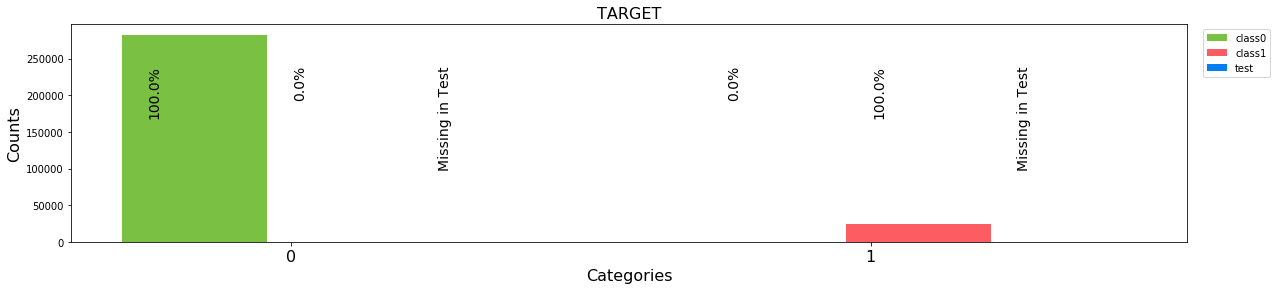

In [4]:
draw_feature_distribution(application_train, 'TARGET')



 DAYS_EMPLOYED


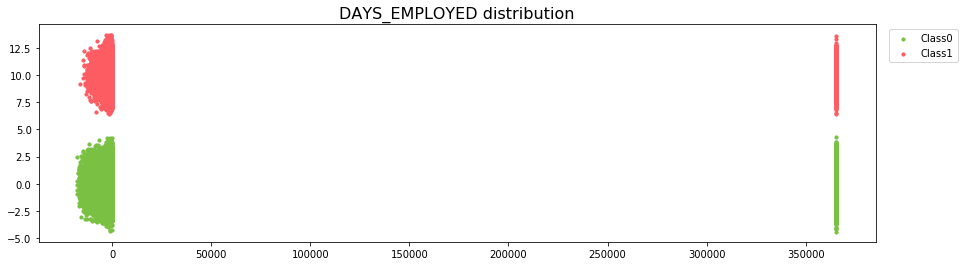

In [5]:
draw_feature_distribution(application_train, 'DAYS_EMPLOYED')
# ToDo(JamesBalcomb): fix "ValueError: max() arg is an empty sequence" - add check for 'class_t_values'

In [ ]:
#EXT_SOURCE_1
#EXT_SOURCE_2
#EXT_SOURCE_3



 EXT_SOURCE_1


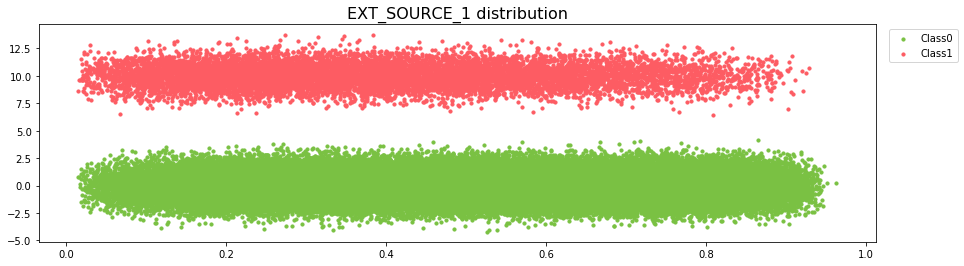

In [6]:
draw_feature_distribution(application_train, 'EXT_SOURCE_1')



 EXT_SOURCE_2


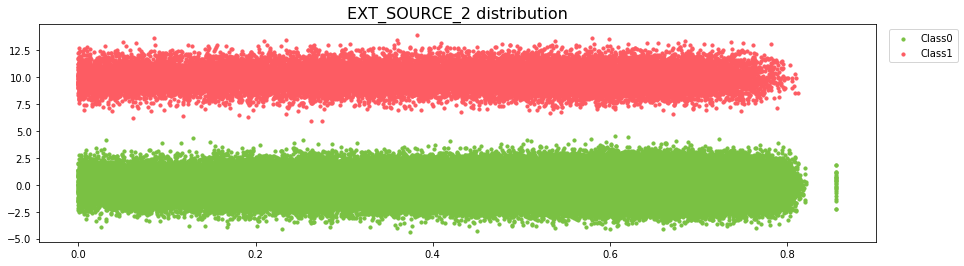

In [7]:
draw_feature_distribution(application_train, 'EXT_SOURCE_2')



 EXT_SOURCE_3


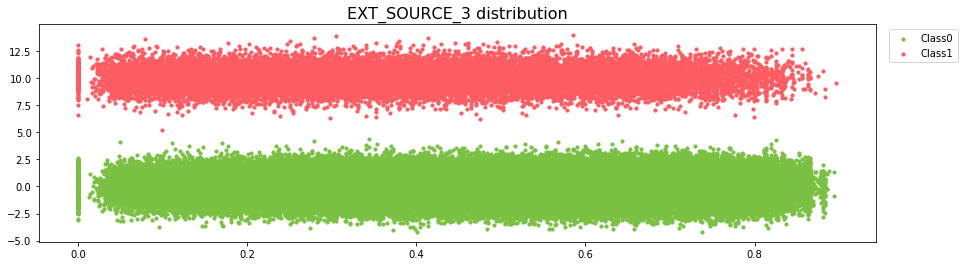

In [8]:
draw_feature_distribution(application_train, 'EXT_SOURCE_3')

# EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3

Q: Is there a relationship between any of these three continuous variables and the binary classification target variable?
A: Yes, but EXT_SOURCE_2 is oddly shapen.

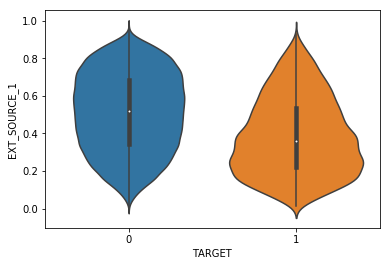

In [9]:
# Seaborn Violin Plot - correlation; distribution and density
sns.violinplot(x='TARGET', y='EXT_SOURCE_1', data=application_train)

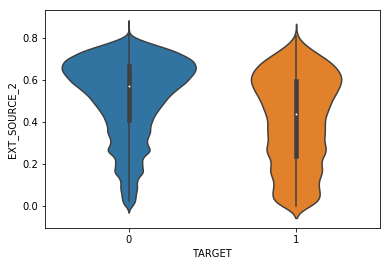

In [10]:
# Seaborn Violin Plot - correlation; distribution and density
sns.violinplot(x='TARGET', y='EXT_SOURCE_2', data=application_train)

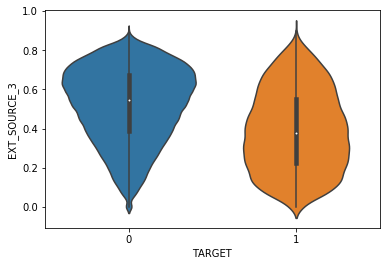

In [11]:
# Seaborn Violin Plot - correlation; distribution and density
sns.violinplot(x='TARGET', y='EXT_SOURCE_3', data=application_train)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001CB6B2E8>]],
      dtype=object)

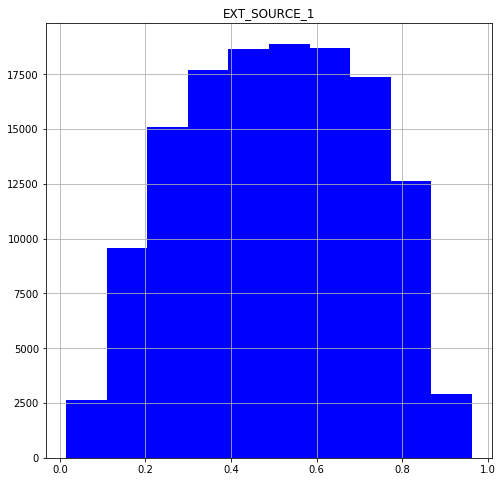

In [13]:
application_train.hist(column='EXT_SOURCE_1', # Column to plot
              figsize=(8,8),                  # Plot size
              color="blue"                    # Plot color
              )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001CAE7518>]],
      dtype=object)

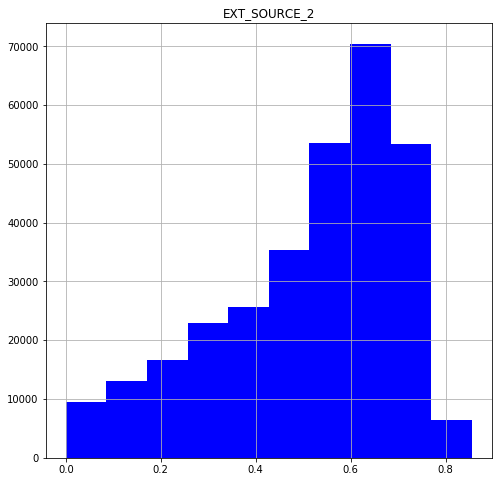

In [14]:
application_train.hist(column='EXT_SOURCE_2', # Column to plot
              figsize=(8,8),                  # Plot size
              color="blue"                    # Plot color
              )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001DC424A8>]],
      dtype=object)

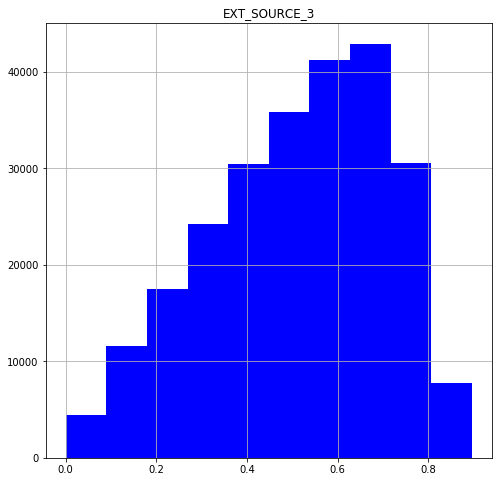

In [15]:
application_train.hist(column='EXT_SOURCE_3', # Column to plot
              figsize=(8,8),                  # Plot size
              color="blue"                    # Plot color
              )

In [22]:
# https://gist.github.com/ltfschoen/4c5d2cf26b8be5355043273493a6b8b9#file-proportions_of_missing_data_in_dataframe_columns-py
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num / den, 2)

In [23]:
get_percentage_missing(application_train['EXT_SOURCE_1'])

0.56

In [24]:
get_percentage_missing(application_train['EXT_SOURCE_2'])

0.0

In [25]:
get_percentage_missing(application_train['EXT_SOURCE_3'])

0.2

In [ ]:
# # https://datascience.stackexchange.com/questions/12645/how-to-count-the-number-of-missing-values-in-each-row-in-pandas-dataframe
# # Count of Missing Values per Column
# df.isnull().sum(axis=0)
# # Count of Missing Values per Row
# df.isnull().sum(axis=1)

In [ ]:
# https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d
# If the missing value isn’t identified as NaN , then we have to first convert or replace such non NaN entry with a NaN.
data_name[‘column_name’].replace(0, np.nan, inplace= True)

In [27]:
# https://gist.github.com/ltfschoen/4c5d2cf26b8be5355043273493a6b8b9#file-proportions_of_missing_data_in_dataframe_columns-py
df = application_train
# Only include columns that contain any NaN values
df_with_any_null_values = df[df.columns[df.isnull().any()].tolist()]

get_percentage_missing(df_with_any_null_values)

# Iterate over columns in DataFrame and delete those with where >30% of the values are null/NaN
for name, values in df_with_any_null_values.iteritems():
    # print("%r: %r" % (name, values))
    if get_percentage_missing(df_with_any_null_values[name]) > 0.30:
        print("Deleting Column %r: " % (name))
        # df_with_any_null_values.drop(name, axis=1, inplace=True)

Deleting Column 'OWN_CAR_AGE': 
Deleting Column 'OCCUPATION_TYPE': 
Deleting Column 'EXT_SOURCE_1': 
Deleting Column 'APARTMENTS_AVG': 
Deleting Column 'BASEMENTAREA_AVG': 
Deleting Column 'YEARS_BEGINEXPLUATATION_AVG': 
Deleting Column 'YEARS_BUILD_AVG': 
Deleting Column 'COMMONAREA_AVG': 
Deleting Column 'ELEVATORS_AVG': 
Deleting Column 'ENTRANCES_AVG': 
Deleting Column 'FLOORSMAX_AVG': 
Deleting Column 'FLOORSMIN_AVG': 
Deleting Column 'LANDAREA_AVG': 
Deleting Column 'LIVINGAPARTMENTS_AVG': 
Deleting Column 'LIVINGAREA_AVG': 
Deleting Column 'NONLIVINGAPARTMENTS_AVG': 
Deleting Column 'NONLIVINGAREA_AVG': 
Deleting Column 'APARTMENTS_MODE': 
Deleting Column 'BASEMENTAREA_MODE': 
Deleting Column 'YEARS_BEGINEXPLUATATION_MODE': 
Deleting Column 'YEARS_BUILD_MODE': 
Deleting Column 'COMMONAREA_MODE': 
Deleting Column 'ELEVATORS_MODE': 
Deleting Column 'ENTRANCES_MODE': 
Deleting Column 'FLOORSMAX_MODE': 
Deleting Column 'FLOORSMIN_MODE': 
Deleting Column 'LANDAREA_MODE': 
Deleting Co

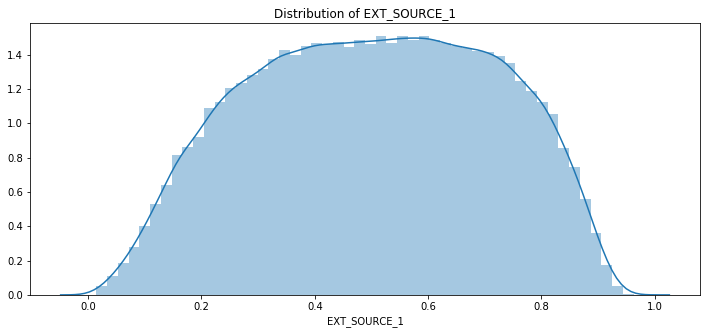

In [29]:
plt.figure(figsize=(12,5))
plt.title("Distribution of EXT_SOURCE_1")
ax = sns.distplot(application_train["EXT_SOURCE_1"].dropna())

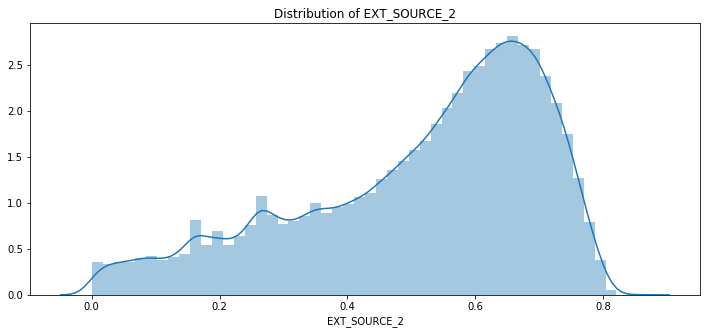

In [34]:
plt.figure(figsize=(12,5))
plt.title("Distribution of EXT_SOURCE_2")
ax = sns.distplot(application_train["EXT_SOURCE_2"].dropna())

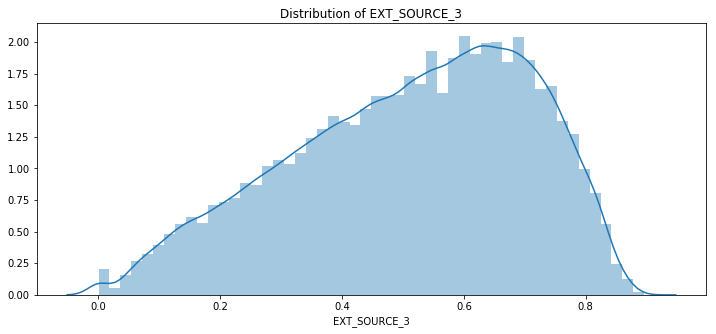

In [35]:
plt.figure(figsize=(12,5))
plt.title("Distribution of EXT_SOURCE_3")
ax = sns.distplot(application_train["EXT_SOURCE_3"].dropna())

In [33]:
application_train['EXT_SOURCE_AVG'] = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

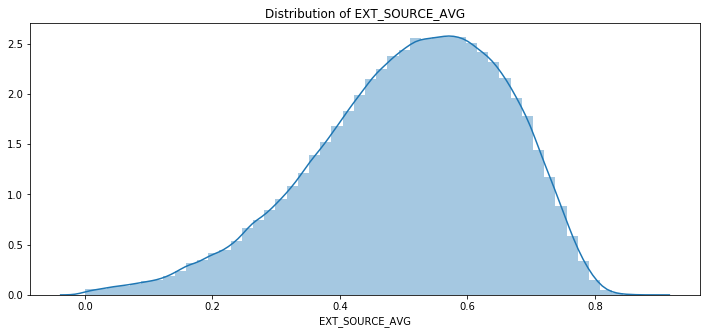

In [36]:
plt.figure(figsize=(12,5))
plt.title("Distribution of EXT_SOURCE_AVG")
ax = sns.distplot(application_train["EXT_SOURCE_AVG"].dropna())

In [38]:
# https://stackoverflow.com/questions/35277075/python-pandas-counting-the-occurrences-of-a-specific-value
#df.loc[df.education == '9th', 'education'].count()
#(df.education == '9th').sum()
#df.query('education == "9th"').education.count()

0

In [42]:
application_train.loc[application_train.EXT_SOURCE_1 == 0.0, 'EXT_SOURCE_1'].count()

0

In [43]:
application_train.loc[application_train.EXT_SOURCE_2 == 0.0, 'EXT_SOURCE_2'].count()

0

In [44]:
application_train.loc[application_train.EXT_SOURCE_3 == 0.0, 'EXT_SOURCE_3'].count()

0